In [127]:
# Copyright (c) 2023-2024 Pietro Luca Mazzacuva <pietroluca.mazzacuva@unicampus.it>
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

import os, sys, subprocess, shlex
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from  tensorflow import keras
from tqdm import tqdm
from REDInet import Utils
from functools import reduce

def give_inputs(cell_line):
    
    if cell_line == "HEK293T":  
        samples = [["outTable_599710609", "outTable_905657585", "outTable_208420383"],
                   ["outTable_572868058", "outTable_364841872", "outTable_814257267"],
                   ["outTable_110067244", "outTable_597789462", "outTable_530905096"]]

        rmsk_file = "rmsk_hg38.sorted.gtf.gz"

    elif cell_line == "HEK":
        samples = [["outTable_724242056", "outTable_816573740"],
                   ["outTable_580067564", "outTable_718392497"],
                   ["outTable_181728208", "outTable_854894021"]]
        rmsk_file = "rmsk.sorted.gtf.gz"

    else:
        samples = [["outTable_192318299", "outTable_436061877"],
                   ["outTable_535670354", "outTable_396704193"],
                   ["outTable_773331943", "outTable_302610513"]]
        rmsk_file = "rmsk.sorted.gtf.gz"
        
    utilities_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/scripts/utilities"   
    files_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/{}".format(cell_line)
    
    return samples, rmsk_file, utilities_path, files_path

def make_predictions(tables, tables_filespath, model_filepath):
    
    model = tf.keras.models.load_model(model_filepath)
    with tqdm(total=int(len(tables)*len(tables[0]))) as pbar:
        for i in range(3):
            for j in range(len(tables[i])):

                intervals = pd.read_table(f"{tables_filespath}/{tables[i][j]}_intervals.tsv", sep="\t")
                X = pd.read_table(f"{tables_filespath}/{tables[i][j]}_feature_vectors.tsv", header=None, sep="\t")
                X_3d = Utils().from_2_to_3_dimensions(X, 8)
                X_3d_log2 = Utils().log_preprocessing(X_3d)
              
                output_table_prefix_filepath = "{}/{}_predictions.tsv".format(tables_filespath, tables[i][j])
                y_hat_proba = model.predict(X_3d_log2, batch_size=512, verbose=0)

                intervals["SNP_Probability"] = 1.0 - y_hat_proba
                intervals["Editing_Probability"] = y_hat_proba

                intervals.to_csv(output_table_prefix_filepath, sep="\t", index=None)
                pbar.update(1)
                
def bona_fide_metrics_calculator(tables, tables_filespath, cells):
    if cells == "HEK293T":
        prefix = "HEK(hg38)"
        suffix_1 = "WT-KO"
        suffix_2 = "OVE-KO"
    elif cells == "a549":
        prefix = cells
        suffix_1 = "WT-SI"
    else:
        prefix = "HEK(hg19)"
        suffix_1 = "WT-KO"
              
    y_true = []
    y_pred = []
    for i in range(len(tables)):
              
        sites = pd.read_table(os.path.join(tables_filespath, f"{tables[i][0]}_{tables[i][1]}_bona_fide_sites.tsv"),
                              sep="\t", usecols=["Region", "Position", "Class"])
              
        cols =  ["Region", "Position", "Strand", "Editing_Probability"]
        wt = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][0]}_predictions.tsv"), sep="\t", usecols=cols)
        adars_inactive = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][1]}_predictions.tsv"), sep="\t", usecols=cols)
        
        wt.loc[:, "index_wt"] = wt.index.tolist()
        adars_inactive.loc[:, "index_adars_inactive"] = adars_inactive.index.tolist()
        merged = wt.merge(adars_inactive, how ="inner", on=["Region", "Position", "Strand"])
        merged = merged.merge(sites, how="inner", on=["Region", "Position"])
        common_pos = merged[merged.loc[:, "Class"]==1]
        index_common_pos = common_pos.loc[:, "index_wt"].tolist()
        merged = merged[merged.loc[:, "Class"]==0]
        index_adars_inactive = merged.loc[:, "index_adars_inactive"].tolist()
        index_wt = merged.loc[:, "index_wt"].tolist()
        snps_adars_inactive = adars_inactive.iloc[index_adars_inactive, :]
        snps_wt = wt.iloc[index_wt, :]
        snps = pd.concat([snps_wt, snps_adars_inactive], axis=0)
        snps.drop(["index_wt", "index_adars_inactive"], axis=1, inplace=True)
        snps.reset_index(drop=True, inplace=True)
        index_drop = index_common_pos + index_wt
        index_drop.sort()
        pos = wt.drop(index_drop)
        pos.reset_index(drop=True, inplace=True)
        pos = pos.merge(sites, how="inner", on=["Region", "Position"])
        pos.reset_index(drop=True, inplace=True)
        
        y_true += [1 for i in range(len(pos))] + [0 for i in range(len(snps))]
        y_pred += pos.loc[:, "Editing_Probability"].tolist() + snps.loc[:, "Editing_Probability"].tolist()
        

    Utils().make_confusion_matrix(y_true,  y_pred,
                                  title = f"{prefix} {suffix_1} Inference Confusion Matrix",
                                  figsize=(6,5),
                                  path=os.path.join(tables_filespath, f"{cells}_{suffix_1}_Inference_Conf_Matrix_on.tiff"))
              
    if cells == "HEK293T":
              
        y_true = []
        y_pred = []
        for i in range(len(tables)):

            sites = pd.read_table(os.path.join(tables_filespath, f"{tables[i][2]}_{tables[i][1]}_bona_fide_sites.tsv"),
                                  sep="\t", usecols=["Region", "Position", "Class"])

            cols =  ["Region", "Position", "Strand", "Editing_Probability"]
            adars_overexpressed = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][2]}_predictions.tsv"), sep="\t", usecols=cols)
            ko = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][1]}_predictions.tsv"), sep="\t", usecols=cols)
            adars_overexpressed.loc[:, "index_adars_overexpressed"] = adars_overexpressed.index.tolist()
            ko.loc[:, "index_ko"] = ko.index.tolist()
            merged = adars_overexpressed.merge(ko, how ="inner", on=["Region", "Position", "Strand"])
            merged = merged.merge(sites, how="inner", on=["Region", "Position"])
            common_pos = merged[merged.loc[:, "Class"]==1]
            index_common_pos = common_pos.loc[:, "index_adars_overexpressed"].tolist()
            merged = merged[merged.loc[:, "Class"]==0]
            index_ko = merged.loc[:, "index_ko"].tolist()
            index_adars_overexpressed = merged.loc[:, "index_adars_overexpressed"].tolist()
            snps_ko = ko.iloc[index_ko, :]
            snps_adars_overexpressed = adars_overexpressed.iloc[index_adars_overexpressed, :]
            snps = pd.concat([snps_adars_overexpressed, snps_ko], axis=0)
            snps.drop(["index_adars_overexpressed", "index_ko"], axis=1, inplace=True)
            snps.reset_index(drop=True, inplace=True)
            index_drop = index_common_pos + index_adars_overexpressed
            index_drop.sort()
            pos = adars_overexpressed.drop(index_drop)
            pos.reset_index(drop=True, inplace=True)
            pos = pos.merge(sites, how="inner", on=["Region", "Position"])
            pos.reset_index(drop=True, inplace=True)

            y_true += [1 for i in range(len(pos))] + [0 for i in range(len(snps))]
            y_pred += pos.loc[:, "Editing_Probability"].tolist() + snps.loc[:, "Editing_Probability"].tolist()
                        
        Utils().make_confusion_matrix(y_true,  y_pred,
                              title = f"{prefix} {suffix_2} Inference Confusion Matrix",
                              figsize=(6,5),
                              path=os.path.join(tables_filespath, f"{cells}_{suffix_2}_Inference_Conf_Matrix_on.tiff"))
    
model_filepath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/REDInet_models/REDInet_log_preprocessing_pos_zeros_snps_29_02_2024_22_25_45.h5"

100%|██████████| 9/9 [00:17<00:00,  1.97s/it]


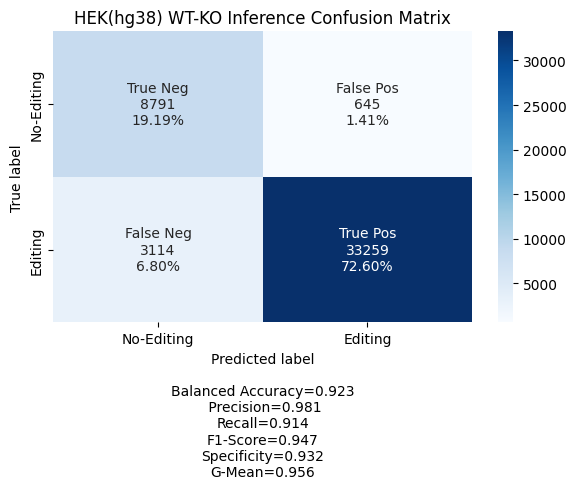

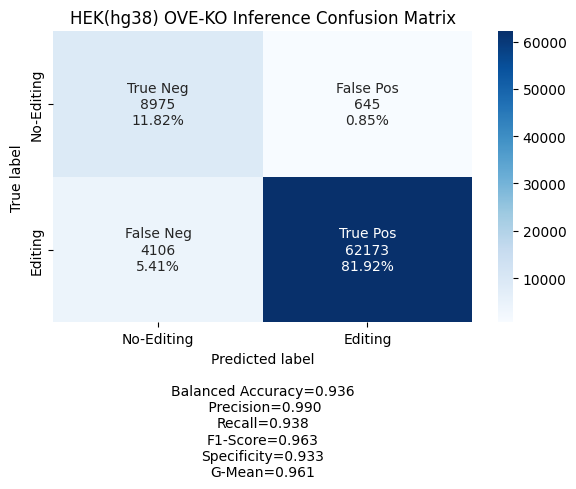

In [8]:
cells = "HEK293T"

tables, rmsk, u_path, filespath =  give_inputs(cells)
make_predictions(tables, filespath, model_filepath)
bona_fide_metrics_calculator(tables, filespath, cells)

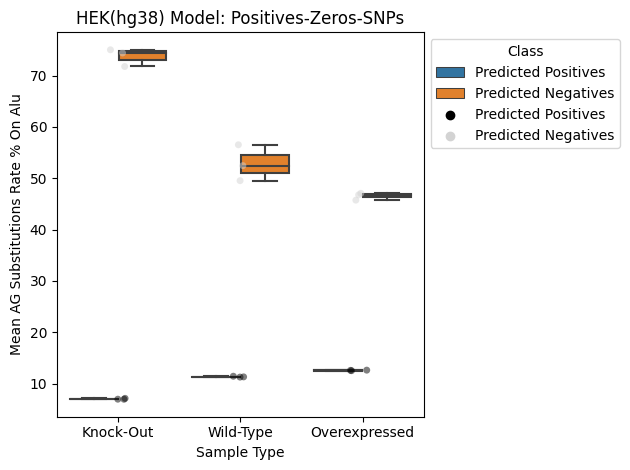

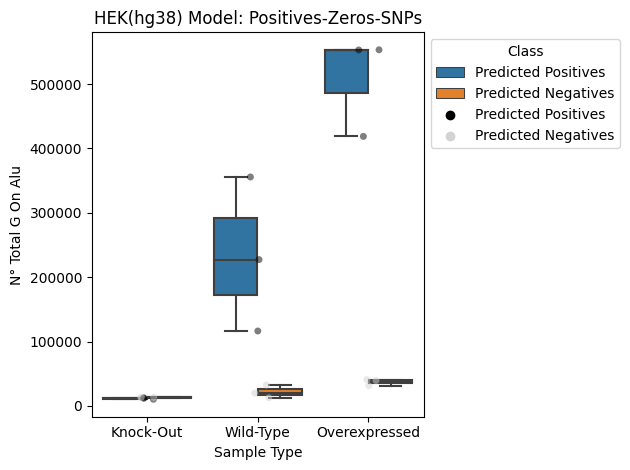

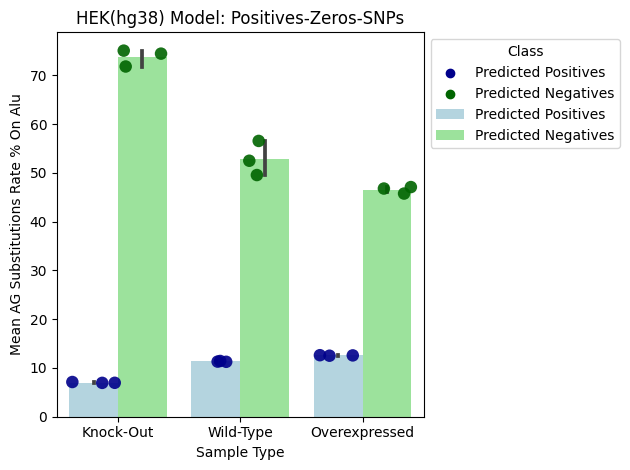

In [11]:
cells = "HEK293T"

tables, rmsk, u_path, filespath =  give_inputs(cells)

def returng(x):
    return eval(x)[2]

annotation = []

for file_name in os.listdir(filespath):
    if file_name.find("bona_fide_sites.tsv") != -1 and file_name.find("candidates") == -1:
        annotation.append(pd.read_csv(os.path.join(filespath, file_name), usecols=["Region", "Position", "RMSK-Reg", "Class"], sep="\t"))
annotation = pd.concat(annotation, axis=0)
annotation = annotation[annotation.loc[:, "RMSK-Reg"].str.find("Alu")!=-1]
annotation.drop("RMSK-Reg", axis=1, inplace=True)
annotation.drop_duplicates(inplace=True)

stats = []
for i in range(3):
    for j in range(3):
        name = "{}_predictions.tsv".format(tables[i][j])
        data = pd.read_table(os.path.join(filespath, name))
        data = data.merge(annotation, how="inner", on=["Region", "Position"])
        data["G"] = data.loc[:, "BasesCounts"].apply(returng)
        data.Class = data.Class.astype("int32")
        pos = data[data.loc[:, "Class"] == 1]
        neg = data[data.loc[:, "Class"] == 0]
        freq = [100*(sum(pos["FreqAGrna"].tolist())/len(pos)), 100*(sum(neg["FreqAGrna"].tolist())/len(neg))]
        g = [sum(pos["G"].tolist()), sum(neg["G"].tolist())]
        df = pd.DataFrame(data = [freq, g]).T
        df.columns = ["Mean AG Substitutions Rate % On Alu", "N° Total G On Alu"]
        df.loc[:, "Class"] = ["Predicted Positives", "Predicted Negatives"]
        if j == 1:
            df.loc[:, "Sample Type"] = "Knock-Out"
        elif j == 0:
            df.loc[:, "Sample Type"] = "Wild-Type"
        else:
            df.loc[:, "Sample Type"] = "Overexpressed"
        df.loc[:, "Model"] = "POSITIVEs+ZEROs+SNPs"
        stats.append(df)
stats = pd.concat(stats, axis=0)
stats.reset_index(drop=True, inplace=True)
stats = stats.iloc[[2,3,8,9,14,15,0,1,6,7,12,13,4,5,10,11,16,17], :]
stats.to_csv(os.path.join(filespath, f"{cells}_boxplot_data.tsv"), sep="\t", index=None)

fig, ax = plt.subplots()

my_palette = {"Predicted Positives": "black", "Predicted Negatives": "lightgrey"}
ax = sn.boxplot(data = stats, x = "Sample Type",  y = "Mean AG Substitutions Rate % On Alu", hue="Class").set(title='HEK(hg38) Model: Positives-Zeros-SNPs')
ax = sn.stripplot(data = stats, x = "Sample Type",  y = "Mean AG Substitutions Rate % On Alu", hue="Class", alpha=0.5, palette=my_palette)
sn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

plt.savefig(f"{filespath}/{cells}_AG_Substitutions_Rate_On_Alu.tiff", dpi=300, 
            bbox_inches='tight', facecolor='white', transparent=False) 

fig, ax = plt.subplots()

my_palette = {"Predicted Positives": "black", "Predicted Negatives": "lightgrey"}
ax = sn.boxplot(data = stats, x = "Sample Type",  y = "N° Total G On Alu", hue="Class").set(title='HEK(hg38) Model: Positives-Zeros-SNPs')
ax = sn.stripplot(data = stats, x = "Sample Type",  y = "N° Total G On Alu", hue="Class", alpha=0.5, palette=my_palette)
sn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

plt.savefig(f"{filespath}/{cells}_Number_Total_G_On_Alu.tiff", dpi=300, 
            bbox_inches='tight', facecolor='white', transparent=False) 


fig, ax = plt.subplots()
palette1 = {"Predicted Positives": "lightblue", "Predicted Negatives": "lightgreen"}
sn.barplot(data=stats, x="Sample Type", y="Mean AG Substitutions Rate % On Alu", hue="Class", 
           fill=True, palette=palette1).set(title='HEK(hg38) Model: Positives-Zeros-SNPs')

palette2 = {"Predicted Positives": "darkblue", "Predicted Negatives": "darkgreen"}
sn.stripplot(data=stats, x="Sample Type", y="Mean AG Substitutions Rate % On Alu", hue="Class",
             dodge=True, size=9, alpha=0.9, jitter=0.40, palette=palette2)
sn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

plt.savefig(f"{filespath}/{cells}_AG_Substitutions_Rate_On_Alu_Barplot.tiff", dpi=300, 
            bbox_inches='tight', facecolor='white', transparent=False) 
plt.show()



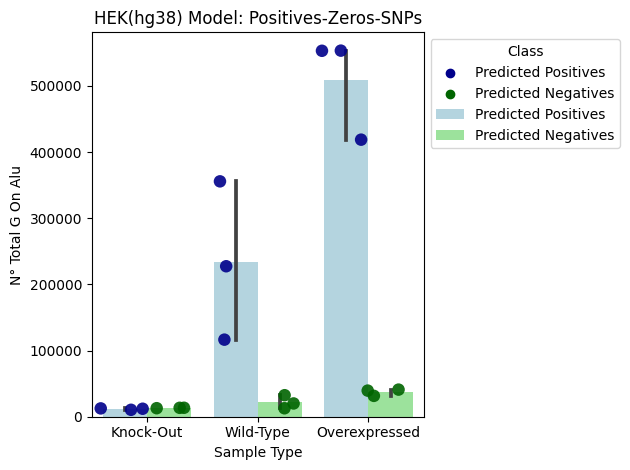

In [12]:
fig, ax = plt.subplots()
palette1 = {"Predicted Positives": "lightblue", "Predicted Negatives": "lightgreen"}
sn.barplot(data=stats, x="Sample Type", y="N° Total G On Alu", hue="Class", 
           fill=True, palette=palette1).set(title='HEK(hg38) Model: Positives-Zeros-SNPs')

palette2 = {"Predicted Positives": "darkblue", "Predicted Negatives": "darkgreen"}
sn.stripplot(data=stats, x="Sample Type", y="N° Total G On Alu", hue="Class",
             dodge=True, size=9, alpha=0.9, jitter=0.45, palette=palette2)
sn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

plt.savefig(f"{filespath}/{cells}_Number_Total_G_On_Alu_Barplot.tiff", dpi=300, 
            bbox_inches='tight', facecolor='white', transparent=False) 
plt.show()

100%|██████████| 6/6 [00:09<00:00,  1.58s/it]


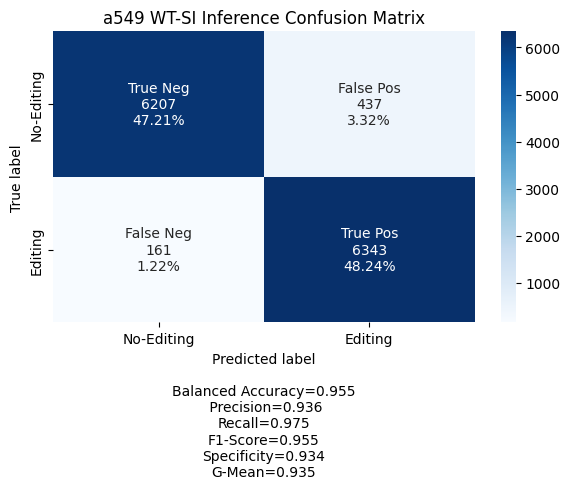

In [9]:
cells = "a549"

tables, rmsk, u_path, filespath =  give_inputs(cells) 
make_predictions(tables, filespath, model_filepath)
bona_fide_metrics_calculator(tables, filespath, cells)

100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


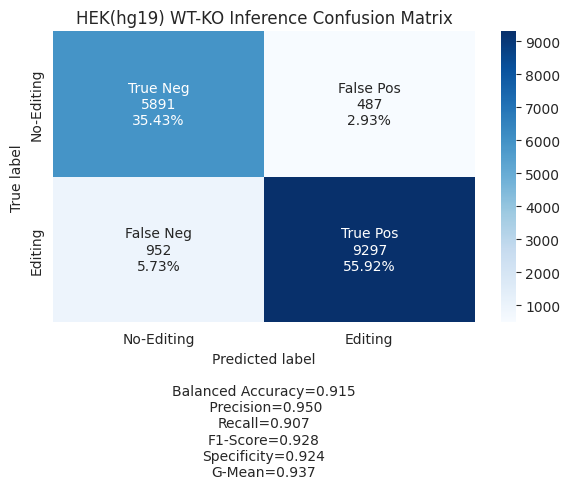

In [128]:
cells = "HEK"

tables, rmsk, u_path, filespath =  give_inputs(cells) 
make_predictions(tables, filespath, model_filepath)
bona_fide_metrics_calculator(tables, filespath, cells)

In [6]:
import os, sys, subprocess, shlex
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from  tensorflow import keras
from tqdm import tqdm
from functools import reduce

def give_inputs(cell_line):
    
    if cell_line == "HEK293T":  
        samples = [["outTable_599710609", "outTable_905657585", "outTable_208420383"],
                   ["outTable_572868058", "outTable_364841872", "outTable_814257267"],
                   ["outTable_110067244", "outTable_597789462", "outTable_530905096"]]

        rmsk_file = "rmsk_hg38.sorted.gtf.gz"

    elif cell_line == "HEK":
        samples = [["outTable_724242056", "outTable_816573740"],
                   ["outTable_580067564", "outTable_718392497"],
                   ["outTable_181728208", "outTable_854894021"]]
        rmsk_file = "rmsk.sorted.gtf.gz"

    else:
        samples = [["outTable_192318299", "outTable_436061877"],
                   ["outTable_535670354", "outTable_396704193"],
                   ["outTable_773331943", "outTable_302610513"]]
        rmsk_file = "rmsk.sorted.gtf.gz"
        
    utilities_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/scripts/utilities"   
    files_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/{}".format(cell_line)
    
    return samples, rmsk_file, utilities_path, files_path


cells = "HEK293T"

samples, rmsk, u_path, filespath = give_inputs(cells)

data = []
for i in range(3):
    df = pd.read_table(f"{filespath}/{samples[i][0]}_{samples[i][1]}_bona_fide_sites.tsv")
    df.loc[:, "Class"] = df.loc[:, "Class"].astype("int32")
    df = df[(df.loc[:, "Class"]==1) & (df.loc[:, "RMSK-Reg"].str.find("Alu")!=-1)]
    data.append(df.loc[:, ["Region", "Position"]])
    df = pd.read_table(f"{filespath}/{samples[i][2]}_{samples[i][1]}_bona_fide_sites.tsv")
    df.loc[:, "Class"] = df.loc[:, "Class"].astype("int32")
    df = df[(df.loc[:, "Class"]==1) & (df.loc[:, "RMSK-Reg"].str.find("Alu")!=-1)]
    data.append(df.loc[:, ["Region", "Position"]])

common = reduce(lambda  first,second: pd.merge(first,second, on=["Region", "Position"],how='inner'), data)
common.to_csv(os.path.join(filespath, "Common_WT_OE_Positives_Alu_Genomic_Positions.tsv"), sep="\t", index=None)

In [20]:
import pysam, os
import numpy as np
import pandas as pd
import tensorflow as tf
from multiprocessing import Pool
from sklearn.preprocessing import OneHotEncoder
from  tensorflow import keras

def return_sum(x):
    return sum(eval(x))

def extraction(cells, sample):    
    
    columns = ["Region", "Position", "Ref", "Strand", "Cov", "Qual", "Bases", "AllSubs", 
               "Freq", "gCov", "gQual", "g[A,C,G,T]", "gAllSubs", "gFreq"]
    
    starttime = datetime.now()
    common_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/{}".format(cells)
    common = pd.read_table(os.path.join(common_path, "Common_WT_OE_Positives_Alu_Genomic_Positions.tsv"), 
                           sep="\t")
    
    prefix = common_path+"/"+sample
    editing = pd.read_table(prefix+".gz", compression="gzip", low_memory=False)
    
    editing.columns = columns
    
    editing.loc[:, "Position"] = editing.loc[:, "Position"].astype("int32")
    editing = editing.merge(common, how="inner", on=["Region", "Position"])
    editing = editing[editing.loc[:, "Bases"].apply(return_sum) >= 50]
    editing.reset_index(drop=True, inplace=True)
    
    print("Total Candidates Alu sites for current sample:", editing.shape[0])
    stoptime = datetime.now()
    print(f"[{datetime.now()}] Identification of Alu Candidates finished for current sample. Elapsed time: {stoptime-starttime}.")
    
    print(f"[{datetime.now()}] Starting extraction of intervals.")
    ohe = OneHotEncoder()
    ohe.fit(np.array(["A", "C", "G", "T"]).reshape(-1, 1))

    intervals = []
    starttime_preds = datetime.now()
    total_extracted = 0
    features_extracted_filepath = prefix+ "Common_WT_OE_Positives_Alu_Genomic_Positions_feature_vectors.tsv"
    features_extracted = open(features_extracted_filepath, "w")

    interval = 101
    df = editing.query("Region != 'chrM'")
    print(f"[{datetime.now()}] Loading reditable with tabix and pysam:", prefix)
    start_time = datetime.now()
    srr = pysam.TabixFile(prefix+".gz")
    with tqdm(total=df.shape[0], position=0, leave=True) as pbar:
        for site in df.itertuples():
            start = int(site.Position) - ((interval-1)/2)
            stop = int(site.Position) + ((interval-1)/2)
            AGrna = eval(site.Bases)[2]/sum(eval(site.Bases))
            srr_interval = []
            for s in srr.fetch(site.Region, start-1, stop):
                srr_interval.append(s.split("\t"))
            srr_interval = pd.DataFrame(srr_interval, columns=columns)
            if srr_interval.shape[0] == interval and len(set(srr_interval["Strand"])) == 1:
                intervals.append([site.Region, site.Position, site.Ref, site.Strand, AGrna, site.Bases, start, stop, stop-start + 1, srr_interval.shape[0]])
                total_extracted += 1
                strand = site.Strand
                seq = srr_interval.Ref.values.reshape(-1,1)
                seq_ohe = ohe.transform(seq).toarray().T
                vects_freqs = []
                strands = []
                vects = []
                for vect in srr_interval["Bases"]:
                    vect = np.array(eval(vect))
                    cov = sum(vect)
                    vect_freqs = vect / cov
                    vects_freqs.append(vect_freqs)
                    vects.append(vect)
                vects_freqs = np.array(vects_freqs).T
                vects = np.array(vects).T
                encoded_site = pd.concat([pd.DataFrame(seq_ohe), pd.DataFrame(vects_freqs)])
                encoded_site.reset_index(drop=True, inplace=True)
                if strand == 0: 
                    encoded_site = pd.DataFrame(np.flip(encoded_site.values, axis=1))
                encoded_site.to_csv(features_extracted, mode="a", sep="\t", header = None, index=None)
            pbar.update(1)
    intervals = pd.DataFrame(intervals)
    print(f"[{datetime.now()}] Total extracted Editing sites: {total_extracted}.")
    stop_time_global = datetime.now()
    print(f"[{datetime.now()}] Features Extraction Finished. Elapsed time {datetime.now()-starttime_preds}.")
    features_extracted.close()
    
    intervals.columns = ["Region", "Position", "RefBase", "Strand", "FreqAGrna", "BasesCounts", "Start", "Stop", "Intlen", "TabixLen"]
    intervals.to_csv(prefix + "Common_WT_OE_Positives_Alu_Genomic_Positions_intervals.tsv", sep="\t", index=None)
    print(f"[{datetime.now()}] Computation Finished. Total Elapsed time: {datetime.now()-starttime}")
    
inputs = []
for i in range(3):
    inputs.append(["HEK293T", samples[i][1]])
    
with Pool(9) as pool:
    pool.starmap(extraction, inputs)

Total Candidates Alu sites for current sample: 9672
[2024-06-17 19:25:51.688981] Identification of Alu Candidates finished for current sample. Elapsed time: 0:06:51.324235.
[2024-06-17 19:25:51.690606] Starting extraction of intervals.
[2024-06-17 19:25:51.700088] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/outTable_905657585


 93%|█████████▎| 8947/9672 [00:49<00:05, 127.64it/s]

Total Candidates Alu sites for current sample: 9656
[2024-06-17 19:26:41.801370] Identification of Alu Candidates finished for current sample. Elapsed time: 0:07:41.436435.
[2024-06-17 19:26:41.803109] Starting extraction of intervals.
[2024-06-17 19:26:41.811860] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/outTable_364841872


100%|██████████| 9672/9672 [00:54<00:00, 178.14it/s]


[2024-06-17 19:26:46.068378] Total extracted Editing sites: 3668.
[2024-06-17 19:26:46.070769] Features Extraction Finished. Elapsed time 0:00:54.377917.
[2024-06-17 19:26:46.095193] Computation Finished. Total Elapsed time: 0:07:45.730478


100%|██████████| 9656/9656 [01:02<00:00, 153.37it/s]


[2024-06-17 19:27:45.035994] Total extracted Editing sites: 3671.
[2024-06-17 19:27:45.038242] Features Extraction Finished. Elapsed time 0:01:03.233072.
[2024-06-17 19:27:45.059914] Computation Finished. Total Elapsed time: 0:08:44.694992
Total Candidates Alu sites for current sample: 9861
[2024-06-17 19:27:58.455506] Identification of Alu Candidates finished for current sample. Elapsed time: 0:08:58.090482.
[2024-06-17 19:27:58.457178] Starting extraction of intervals.
[2024-06-17 19:27:58.466514] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/outTable_597789462


100%|██████████| 9861/9861 [00:57<00:00, 171.44it/s]


[2024-06-17 19:28:56.180348] Total extracted Editing sites: 3742.
[2024-06-17 19:28:56.182332] Features Extraction Finished. Elapsed time 0:00:57.723094.
[2024-06-17 19:28:56.203311] Computation Finished. Total Elapsed time: 0:09:55.838325


In [143]:
import os, sys, pysam
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from  tensorflow import keras
from tqdm import tqdm
from functools import reduce
from multiprocessing import Pool
from sklearn.preprocessing import OneHotEncoder
from  tensorflow import keras
from datetime import datetime

def give_inputs(cell_line):
    
    if cell_line == "HEK293T":  
        samples = [["outTable_599710609", "outTable_905657585", "outTable_208420383"],
                   ["outTable_572868058", "outTable_364841872", "outTable_814257267"],
                   ["outTable_110067244", "outTable_597789462", "outTable_530905096"]]

    elif cell_line == "HEK":
        samples = [["outTable_724242056", "outTable_816573740"],
                   ["outTable_580067564", "outTable_718392497"],
                   ["outTable_181728208", "outTable_854894021"]]
        rmsk_file = "rmsk.sorted.gtf.gz"

    else:
        samples = [["outTable_192318299", "outTable_436061877"],
                   ["outTable_535670354", "outTable_396704193"],
                   ["outTable_773331943", "outTable_302610513"]]
         
    files_path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/{}".format(cell_line)
    
    return samples, files_path

def extraction(cells, sample, files_path):    
    
    columns = ["Region", "Position", "Ref", "Strand", "Cov", "Qual", "Bases", "AllSubs", 
               "Freq", "gCov", "gQual", "g[A,C,G,T]", "gAllSubs", "gFreq"]
    
    starttime = datetime.now()
    
    common = pd.read_table(os.path.join(files_path, "Common_OE_Positives_Alu_Genomic_Positions.tsv"), 
                           sep="\t")
    
    prefix = files_path+"/"+sample
    editing = pd.read_table(prefix+".gz", compression="gzip", low_memory=False)
    
    editing.columns = columns
    
    editing.loc[:, "Position"] = editing.loc[:, "Position"].astype("int32")
    editing = editing.merge(common, how="inner", on=["Region", "Position"])
    #editing = editing[editing.loc[:, "Bases"].apply(return_sum) >= 50]
    editing.reset_index(drop=True, inplace=True)
    
    print("Total Candidates Alu sites for current sample:", editing.shape[0])
    stoptime = datetime.now()
    print(f"[{datetime.now()}] Identification of Alu Candidates finished for current sample. Elapsed time: {stoptime-starttime}.")
    
    print(f"[{datetime.now()}] Starting extraction of intervals.")
    ohe = OneHotEncoder()
    ohe.fit(np.array(["A", "C", "G", "T"]).reshape(-1, 1))

    intervals = []
    starttime_preds = datetime.now()
    total_extracted = 0
    features_extracted_filepath = prefix+ "Common_OE_Positives_Alu_Genomic_Positions_feature_vectors.tsv"
    features_extracted = open(features_extracted_filepath, "w")

    interval = 101
    df = editing.query("Region != 'chrM'")
    print(f"[{datetime.now()}] Loading reditable with tabix and pysam:", prefix)
    start_time = datetime.now()
    srr = pysam.TabixFile(prefix+".gz")
    with tqdm(total=df.shape[0], position=0, leave=True) as pbar:
        for site in df.itertuples():
            start = int(site.Position) - ((interval-1)/2)
            stop = int(site.Position) + ((interval-1)/2)
            AGrna = eval(site.Bases)[2]/sum(eval(site.Bases))
            srr_interval = []
            for s in srr.fetch(site.Region, start-1, stop):
                srr_interval.append(s.split("\t"))
            srr_interval = pd.DataFrame(srr_interval, columns=columns)
            if srr_interval.shape[0] == interval and len(set(srr_interval["Strand"])) == 1:
                intervals.append([site.Region, site.Position, site.Ref, site.Strand, AGrna, site.Bases, start, stop, stop-start + 1, srr_interval.shape[0]])
                total_extracted += 1
                strand = site.Strand
                seq = srr_interval.Ref.values.reshape(-1,1)
                seq_ohe = ohe.transform(seq).toarray().T
                vects_freqs = []
                strands = []
                vects = []
                for vect in srr_interval["Bases"]:
                    vect = np.array(eval(vect))
                    cov = sum(vect)
                    vect_freqs = vect / cov
                    vects_freqs.append(vect_freqs)
                    vects.append(vect)
                vects_freqs = np.array(vects_freqs).T
                vects = np.array(vects).T
                encoded_site = pd.concat([pd.DataFrame(seq_ohe), pd.DataFrame(vects_freqs)])
                encoded_site.reset_index(drop=True, inplace=True)
                if strand == 0: 
                    encoded_site = pd.DataFrame(np.flip(encoded_site.values, axis=1))
                encoded_site.to_csv(features_extracted, mode="a", sep="\t", header = None, index=None)
            pbar.update(1)
    intervals = pd.DataFrame(intervals)
    print(f"[{datetime.now()}] Total extracted Alu sites: {total_extracted}.")
    stop_time_global = datetime.now()
    print(f"[{datetime.now()}] Features Extraction Finished. Elapsed time {datetime.now()-starttime_preds}.")
    features_extracted.close()
    
    intervals.columns = ["Region", "Position", "RefBase", "Strand", "FreqAGrna", "BasesCounts", 
                         "Start", "Stop", "Intlen", "TabixLen"]
    intervals.to_csv(prefix + "_Common_OE_Positives_Alu_Genomic_Positions_intervals.tsv", 
                     sep="\t", index=None)
    print(f"[{datetime.now()}] Computation Finished. Total Elapsed time: {datetime.now()-starttime}")
    
def return_class(x):
    if x > 0.5:
        Class = 1
    else:
        Class = 0
    return Class
    
def make_predictions(tables, tables_filespath, model_filepath):
    
    model = tf.keras.models.load_model(model_filepath)
    with tqdm(total=int(len(tables)*len(tables[0]))) as pbar:
        for i in range(3):
            for j in range(len(tables[i])):
                
                prefix = "{}_Common_OE_Positives_Alu_Genomic_Positions".format(tables[i][j])
                output_table_prefix_filepath = "{}/{}_predictions.tsv".format(tables_filespath, prefix)
                
                if j <=1 :
                    
                    intervals = pd.read_table(os.path.join(tables_filespath, prefix+"_intervals.tsv"), sep="\t")
                    X = pd.read_table(os.path.join(tables_filespath, prefix+"_feature_vectors.tsv"),
                                      header=None, sep="\t")
                    X_3d = Utils().from_2_to_3_dimensions(X, 8)
                    X_3d_log2 = Utils().log_preprocessing(X_3d)

                    y_hat_proba = model.predict(X_3d_log2, batch_size=512, verbose=0)

                    intervals.loc[:, "SNP_Probability"] = 1.0 - y_hat_proba
                    intervals.loc[:, "Editing_Probability"] = y_hat_proba
                    intervals.loc[:, "Class"] = intervals.loc[:, "Editing_Probability"].apply(return_class)

                    intervals.to_csv(output_table_prefix_filepath, sep="\t", index=None)
                    pbar.update(1)       
                    
                else:
                    
                    common = pd.read_table(os.path.join(tables_filespath, 
                                                        "Common_OE_Positives_Alu_Genomic_Positions.tsv"))
                    predictions = pd.read_table(os.path.join(tables_filespath, 
                                                             f"{tables[i][j]}_predictions.tsv"))
                    
                    predictions.loc[:, "Position"] = predictions.loc[:, "Position"].astype("int32")
                    
                    predictions = predictions.merge(common, how="inner", on=["Region", "Position"])
                    predictions.loc[:, "Class"] = predictions.loc[:, "Editing_Probability"].apply(return_class)
                    
                    predictions.to_csv(output_table_prefix_filepath, sep="\t", index=None)
                    pbar.update(1)  
                    
def return_A(bases_counts):
    return eval(bases_counts)[0]

def return_G(bases_counts):
    return eval(bases_counts)[2]
            
modelfilepath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/REDInet_models/REDInet_log_preprocessing_pos_zeros_snps_29_02_2024_22_25_45.h5"

In [22]:
cells = "HEK293T"

samples, filespath = give_inputs(cells)

data = []
for i in range(3):
    df = pd.read_table(f"{filespath}/{samples[i][2]}_{samples[i][1]}_bona_fide_sites.tsv")
    df.loc[:, "Class"] = df.loc[:, "Class"].astype("int32")
    df = df[(df.loc[:, "Class"]==1) & (df.loc[:, "RMSK-Reg"].str.find("Alu")!=-1)]
    data.append(df.loc[:, ["Region", "Position"]])

common = reduce(lambda  first,second: pd.merge(first,second, on=["Region", "Position"],how='inner'), data)
common.to_csv(os.path.join(filespath, "Common_OE_Positives_Alu_Genomic_Positions.tsv"), 
              sep="\t", index=None)

print(f"[{datetime.now()}] Total extracted Alu Positives Sites on OE samples: {common.shape[0]}.")
del common, data

def return_sum(x):
    return sum(eval(x))
    
inputs = []
for i in range(3):
    inputs.append(["HEK293T", samples[i][0], filespath])
    inputs.append(["HEK293T", samples[i][1], filespath])
    
with Pool(9) as pool:
    pool.starmap(extraction, inputs)

[2024-06-18 06:42:43.135635] Total extracted Alu Positives Sites on OE samples: 31033.
Total Candidates Alu sites for current sample: 31006
[2024-06-18 06:47:47.010045] Identification of Alu Candidates finished for current sample. Elapsed time: 0:05:03.759194.
[2024-06-18 06:47:47.011493] Starting extraction of intervals.
[2024-06-18 06:47:47.049658] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/outTable_905657585


 31%|███       | 9469/31006 [00:33<01:37, 221.48it/s]

Total Candidates Alu sites for current sample: 31031
[2024-06-18 06:48:20.565445] Identification of Alu Candidates finished for current sample. Elapsed time: 0:05:37.314055.
[2024-06-18 06:48:20.566827] Starting extraction of intervals.
[2024-06-18 06:48:20.591863] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/outTable_110067244


  6%|▌         | 1814/31031 [00:09<02:33, 190.93it/s]]

Total Candidates Alu sites for current sample: 31033
[2024-06-18 06:48:31.007147] Identification of Alu Candidates finished for current sample. Elapsed time: 0:05:47.755942.
[2024-06-18 06:48:31.008493] Starting extraction of intervals.
[2024-06-18 06:48:31.026243] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/outTable_364841872


 18%|█▊        | 5730/31033 [00:25<01:28, 285.68it/s]]

Total Candidates Alu sites for current sample: 31018
[2024-06-18 06:48:56.383159] Identification of Alu Candidates finished for current sample. Elapsed time: 0:06:13.131610.
[2024-06-18 06:48:56.384565] Starting extraction of intervals.


 62%|██████▏   | 19367/31006 [01:09<00:58, 198.26it/s]

[2024-06-18 06:48:56.405295] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/outTable_597789462


 64%|██████▍   | 19815/31031 [01:16<00:39, 281.76it/s]

[2024-06-18 06:49:37.427358] Total extracted Alu sites: 12248.
[2024-06-18 06:49:37.428970] Features Extraction Finished. Elapsed time 0:01:50.415424.
[2024-06-18 06:49:37.478265] Computation Finished. Total Elapsed time: 0:06:54.227440


100%|██████████| 31031/31031 [01:58<00:00, 260.96it/s]


[2024-06-18 06:50:19.931918] Total extracted Alu sites: 12318.

 88%|████████▊ | 27178/31033 [01:48<00:12, 297.77it/s]


[2024-06-18 06:50:19.933815] Features Extraction Finished. Elapsed time 0:01:59.364956.
[2024-06-18 06:50:20.003631] Computation Finished. Total Elapsed time: 0:07:36.752268


100%|██████████| 31033/31033 [02:03<00:00, 251.45it/s]


[2024-06-18 06:50:34.627403] Total extracted Alu sites: 12298.
[2024-06-18 06:50:34.629326] Features Extraction Finished. Elapsed time 0:02:03.618912.
[2024-06-18 06:50:34.686176] Computation Finished. Total Elapsed time: 0:07:51.435008


 88%|████████▊ | 27432/31018 [01:37<00:12, 295.77it/s]

Total Candidates Alu sites for current sample: 31033
[2024-06-18 06:50:34.742502] Identification of Alu Candidates finished for current sample. Elapsed time: 0:07:51.491476.
[2024-06-18 06:50:34.743817] Starting extraction of intervals.
[2024-06-18 06:50:34.760711] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/outTable_572868058


100%|██████████| 31018/31018 [01:49<00:00, 282.43it/s]


[2024-06-18 06:50:46.644416] Total extracted Alu sites: 12293.
[2024-06-18 06:50:46.646116] Features Extraction Finished. Elapsed time 0:01:50.259602.


  9%|▊         | 2703/31033 [00:11<01:57, 240.29it/s]

[2024-06-18 06:50:46.696868] Computation Finished. Total Elapsed time: 0:08:03.445341


 97%|█████████▋| 30135/31033 [01:53<00:03, 269.74it/s]

Total Candidates Alu sites for current sample: 31033
[2024-06-18 06:52:28.507926] Identification of Alu Candidates finished for current sample. Elapsed time: 0:09:45.257222.
[2024-06-18 06:52:28.509489] Starting extraction of intervals.
[2024-06-18 06:52:28.534074] Loading reditable with tabix and pysam: /lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/outTable_599710609


100%|██████████| 31033/31033 [01:56<00:00, 265.51it/s]


[2024-06-18 06:52:31.762553] Total extracted Alu sites: 12397.
[2024-06-18 06:52:31.764132] Features Extraction Finished. Elapsed time 0:01:57.018270.
[2024-06-18 06:52:31.822013] Computation Finished. Total Elapsed time: 0:09:48.571011


100%|██████████| 31033/31033 [02:35<00:00, 199.61it/s]


[2024-06-18 06:55:04.155503] Total extracted Alu sites: 12449.
[2024-06-18 06:55:04.157815] Features Extraction Finished. Elapsed time 0:02:35.645578.
[2024-06-18 06:55:04.217093] Computation Finished. Total Elapsed time: 0:12:20.966418


In [35]:
cells = "HEK293T"

samples, filespath = give_inputs(cells)

make_predictions(samples, filespath, modelfilepath)

100%|██████████| 9/9 [00:12<00:00,  1.34s/it]


In [146]:
cells = "HEK293T"

samples, filespath = give_inputs(cells)

comparative_table = []

for i in range(3):
    for j in range(len(samples[i])):
        
        name = "{}_Common_OE_Positives_Alu_Genomic_Positions_predictions.tsv".format(samples[i][j])
        df = pd.read_table(os.path.join(filespath, name), usecols=["Region", "Position", "BasesCounts", "Class", ])
        df.columns = ["Region", "Position", f"{samples[i][j]} BasesCounts", f"{samples[i][j]} Predicted Class"]
        
        comparative_table.append(df)
        
comparative_table = reduce(lambda  first,second: pd.merge(first,second, on=["Region", "Position"],
                                                          how='inner'), comparative_table)
comparative_table.to_csv(os.path.join(filespath, 
                                      "Common_OE_Positives_Alu_Genomic_Positions_Comparative_table.tsv"), 
                         sep="\t", index=None)

print(f"Total Number of Common Alu Sites: {comparative_table.shape[0]}")

stats = []

for i in range(3):
    for j in range(len(samples[i])):
        
        if j == 0:
            genotype = "ADAR1 Wild-Type"
        elif j ==1:
            genotype = "ADAR1 Knock-Out"
        else:
            genotype = "ADAR1 Overexpressed"
        
        number_of_positives = comparative_table.loc[:,  f"{samples[i][j]} Predicted Class"].value_counts(normalize=True)[1]
        number_of_positives = number_of_positives*100
        a_to_g = comparative_table[comparative_table.loc[:,  f"{samples[i][j]} Predicted Class"] == 1]
        a_to_g.loc[:, f"{samples[i][j]} Raw_A"] = a_to_g.loc[:, f"{samples[i][j]} BasesCounts"].apply(return_A)
        tot_A = sum(a_to_g.loc[:,  f"{samples[i][j]} Raw_A"].tolist())
        a_to_g.loc[:, f"{samples[i][j]} Raw_G"] = a_to_g.loc[:, f"{samples[i][j]} BasesCounts"].apply(return_G)
        tot_G = sum(a_to_g.loc[:,  f"{samples[i][j]} Raw_G"].tolist())
        alu_index = 100*(tot_G/(tot_A+tot_G))
        
        stats.append([genotype, i+1, number_of_positives, alu_index])
        
stats = pd.DataFrame(stats, columns=["Genotype", "Sample Number", 
                                     "N° Predicted Positives in pct.", 
                                     "Alu Index (Value x 100)"])

stats = stats.iloc[[1, 4, 6, 0, 3, 5, 2, 5, 7], :]
stats.to_csv(os.path.join(filespath, "HEK293T_Common_Alu_Barplots_Data.tsv"), sep="\t", index=None)

Total Number of Common Alu Sites: 11847


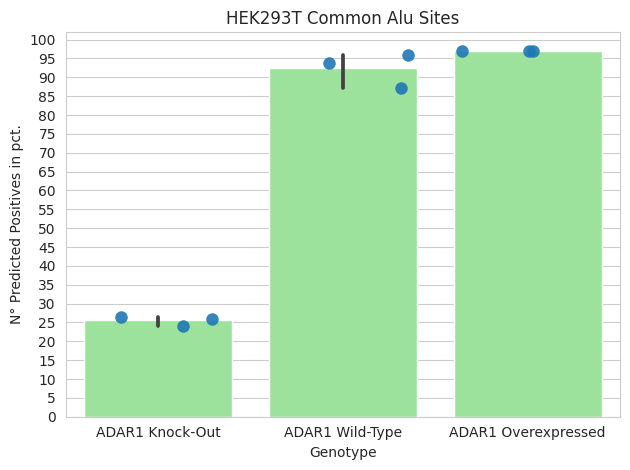

In [142]:
fig, ax = plt.subplots()
ax.set_yticks(np.arange(0,105, 5))

with sn.axes_style("whitegrid"):
    sn.barplot(data=stats, x="Genotype", y="N° Predicted Positives in pct.", 
               fill=True, color="lightgreen").set(title='HEK293T Common Alu Sites')

    sn.stripplot(data=stats, x="Genotype", y="N° Predicted Positives in pct.",
                 dodge=True, size=9, alpha=0.9, jitter=0.40)

    fig.tight_layout()

    plt.savefig(f"{filespath}/{cells}_Number_Predicted_Positives_On_Common_Alu_Sites_Barplot.tiff", dpi=600, 
                bbox_inches='tight', facecolor='white', transparent=False) 
    plt.show()

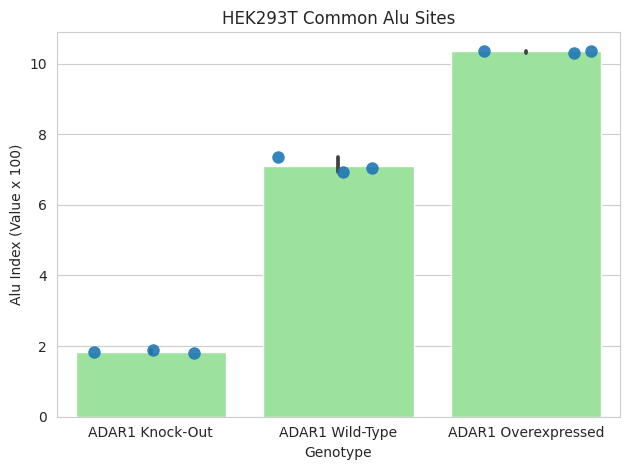

In [149]:
fig, ax = plt.subplots()

with sn.axes_style("whitegrid"):
    sn.barplot(data=stats, x="Genotype", y="Alu Index (Value x 100)", 
               fill=True, color="lightgreen").set(title='HEK293T Common Alu Sites')

    sn.stripplot(data=stats, x="Genotype", y="Alu Index (Value x 100)",
                 dodge=True, size=9, alpha=0.9, jitter=0.40)

    fig.tight_layout()

    plt.savefig(f"{filespath}/{cells}_Alu_Index_On_Common_Alu_Sites_Barplot.tiff", dpi=600, 
                bbox_inches='tight', facecolor='white', transparent=False) 
    plt.show()